In [1]:
# -*- coding: utf-8 -*-

# 대신증권 CYBOS API에서 데이터 가져오기

`python 37-32bit`

conda 등의 interpreter가 Admin으로 실행되어야. 

Cybos는 Windows에서 돌릴 시 region settings나 font에 따라 한글이 깨지기도 함. 

`Control Panel > Region > Administrative > Language for non-Unicode programs`에서 `Korean(Korea) & uncheck Beta: Use Unicode UTF-8 for worldwide language support` 선택

In [60]:
import platform
platform.architecture()

('32bit', 'WindowsPE')

In [88]:
import win32com.client

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date
import re

## 연결 확인

In [62]:
instCpCybos = win32com.client.Dispatch('CpUtil.CpCybos')
instCpCybos.IsConnect

1

In [63]:
instCpCybos.ServerType

2

## 종목코드 반환: 분류별

In [64]:
instCpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")

In [65]:
kospi_ticker_list = instCpCodeMgr.GetStockListByMarket(1)
kosdaq_ticker_list = instCpCodeMgr.GetStockListByMarket(2)

In [66]:
kospi_ticker_list[:10]

('A000020',
 'A000040',
 'A000050',
 'A000060',
 'A000070',
 'A000075',
 'A000080',
 'A000087',
 'A000100',
 'A000105')

In [67]:
def stock_ticker2name(ticker):
    """Convert ticker code to comapny name. 
    
    Args: 
        ticker (str): The company's ticker code.
        
    Returns:
        str.
        The company's name.
    
    """
    name = instCpCodeMgr.CodeToName(ticker)
    return name

In [68]:
stock_ticker2name('A005930')

'삼성전자'

## 종목코드 반환: 회사명

In [69]:
instCpStockCode = win32com.client.Dispatch("CpUtil.CpStockCode")

In [70]:
def stock_name2ticker(name):
    """Convert company name to ticker code. 
    
    Args: 
        name (str): The company's name.
        
    Returns:
        str.
        The company's ticker code.
    
    """
    ticker = instCpStockCode.NameToCode(name)
    if ticker == '':
        return None
    else:
        return ticker

In [71]:
stock_name2ticker('삼성전자')

'A005930'

## 종목의 주가 데이터 반환

In [72]:
instStockChart = win32com.client.Dispatch('CpSysDib.StockChart')

In [73]:
today = date.today().strftime('%Y%m%d')
today

'20200403'

In [74]:
data_columns_cipher = {
    0: 'date', # 날짜
    1: 'time', # 시간
    2: 'open', # 시가
    3: 'high', # 고가
    4: 'low', # 저가
    5: 'close', # 종가
    6: 'pct_change', # 전일대비
    8: 'volume', # 거래량
    9: 'trading_volume', # 거래대금
    10: 'cum_filled_vol_sold', # 누적체결매도수량 -호가비교방식누적체결매도수량
    11: 'cum_filled_vol_bought', # 누적체결매수수량 -호가비교방식누적체결매수수량
    12: 'outstanding_shares', # 상장주식수
    13: 'market_cap', # 시가총액
    14: 'foreigner_order_limit1', # 외국인주문한도수량
    15: 'foreigner_order_limit2', # 외국인주문가능수량
    16: 'foreigner_position', # 외국인현보유수량
    17: 'foreigner_position_ratio', # 외국인현보유비율
    18: 'adj_date', # 수정주가일자 - YYYYMMDD
    19: 'adj_price_ratio', # 수정주가비율
    20: 'inst_net_buy', # 기관순매수
    21: 'inst_cum_net_buy', # 기관누적순매수
    22: 'adv_dec_line', # 등락주선 (advance-decline line)
    23: 'adv_dec_ratio', # 등락비율 (advance decline ratio)
    24: 'deposit', # 예탁금
    25: 'turnover', # 주식회전율
    26: 'deals_ratio', # 거래성립률(ratio of deals) 
    37: 'change_plus_minus', # 대비부호
}


<h3 style='color:red;'>TODO: W(주), M(월) 고치기</h3>

In [126]:
def get_ohlcv(company, end_date=today, verbose=False, **kwargs):
    """Get ohlcv price data of a stock. 
    
    If "time_interval" is 'D'(day), 'W'(week), or 'M'(month) "time" is ignored from the "datetime" column.
    
    Args: 
        company (str): The stock's name or ticker code.
        end_date (str): YYYYmmdd formatted date. 
    
    Kwargs:
        data_size (int): The number of data(rows) requested to the API. Default=1000
        data_columns (list): List of columns to retrieve. Default=[0, 1, 2, 3, 4, 5, 8] (date + time+ ohlcv)
            0:날짜(ulong) # Always include date.
            1:시간(long) - hhmm # Always include time.
            2:시가(long or float)
            3:고가(long or float)
            4:저가(long or float)
            5:종가(long or float)
            6:전일대비(long or float) - 주) 대비부호(37)과반드시같이요청해야함
            8:거래량(ulong or ulonglong)주) 정밀도만원단위
            9:거래대금(ulonglong)
            10:누적체결매도수량(ulong or ulonglong) -호가비교방식누적체결매도수량
            11:누적체결매수수량(ulong or ulonglong) -호가비교방식누적체결매수수량
             (주) 10, 11 필드는분,틱요청일때만제공
            12:상장주식수(ulonglong)
            13:시가총액(ulonglong)
            14:외국인주문한도수량(ulong)
            15:외국인주문가능수량(ulong)
            16:외국인현보유수량(ulong)
            17:외국인현보유비율(float)
            18:수정주가일자(ulong) - YYYYMMDD
            19:수정주가비율(float)
            20:기관순매수(long)
            21:기관누적순매수(long)
            22:등락주선(long)
            23:등락비율(float)
            24:예탁금(ulonglong)
            25:주식회전율(float)
            26:거래성립률(float)
            37:대비부호(char) - 수신값은 GetHeaderValue 8 대비부호와동일
        time_interval (str): Chart interval to use. Default='D'
            'D': 일
            'W': 주
            'M': 월
            'm': 분
            'T': 틱

    Returns:
        (pandas dataframe) Price data dataframe. 
            
    """
    
    ## Check if company name/ticker exists. 
    if stock_ticker2name(company) or stock_name2ticker(company):
        ticker = stock_ticker2name(company) or stock_name2ticker(company)
    else:
        print('This company does not exist.')
        return
    
    ## Get data from the API
    data_size = kwargs.get('data_size', 1000)
    data_columns = kwargs.get('data_columns', [0, 1, 2, 3, 4, 5, 8]) # date + time + ohlcv
    time_interval = kwargs.get('time_interval', 'D')
    
    instStockChart.SetInputValue(0, ticker) # 0.종목코드
    instStockChart.SetInputValue(1, ord('2')) # 1.기간/요청설정 = {1: 기간으로 요청, 2: 개수로 요청}
    instStockChart.SetInputValue(2, end_date) # 2.가장최근날짜
    instStockChart.SetInputValue(4, data_size) # 4.요청개수설정
    instStockChart.SetInputValue(5, data_columns) # 5.데이터 column들 
    instStockChart.SetInputValue(6, ord(time_interval)) # 6.시간간격
    instStockChart.SetInputValue(9, ord('1')) # 9.수정주가 = {0: 무수정주가, 1: 수정주가}
    
    instStockChart.BlockRequest()
    
    if verbose:
        print("""
        Header information

        Ticker: {ticker}
        Name: {name}
        Field names: {field_names}
        Data count: {data_count}
        """.format(
            ticker=instStockChart.GetHeaderValue(0),
            name=stock_ticker2name(instStockChart.GetHeaderValue(0)),
            field_names=instStockChart.GetHeaderValue(2),
            data_count=instStockChart.GetHeaderValue(3),
        ))
    
    ## Create a dataframe from the retrieved data. 
    df_diclist = []
    
    data_count = instStockChart.GetHeaderValue(3)
    fields_count = instStockChart.GetHeaderValue(1)
    
    for i in range(data_count):
        row_dic = {}
        for idx, column_code in enumerate(data_columns):
            row_dic[data_columns_cipher[column_code]] = instStockChart.GetDataValue(idx, i)

        df_diclist.append(row_dic)
        
    df = pd.DataFrame(df_diclist)
    
    df.date = pd.to_datetime(df.date, format='%Y%m%d')
    
    try:
        df.time = pd.to_datetime(df.time, format='%H%M').dt.time
        df.loc[:, 'datetime'] = pd.to_datetime(df.date.astype(str) + ' ' + df.time.astype(str))
        df.drop(['date', 'time'], axis=1, inplace=True)
    except:
        df.drop('time', axis=1, inplace=True)
        df.rename(columns={'date':'datetime'}, inplace=True)
    df = df.set_index('datetime')
    
    return df
    

In [142]:
samsung = get_ohlcv('삼성전자', verbose=True, data_size=10000, time_interval='D')
samsung


        Header information

        Ticker: A005930
        Name: 삼성전자
        Field names: ('날짜', '시간', '시가', '고가', '저가', '종가', '거래량')
        Data count: 2856
        


,open,high,low,close,volume
datetime,,,,,
2020-04-03,47400,47600,46550,47000,22784682
2020-04-02,46200,46850,45350,46800,21621076
2020-04-01,47450,47900,45800,45800,27259532
2020-03-31,48000,48500,47150,47750,30654261
2020-03-30,47050,48350,46550,47850,26797395
...,...,...,...,...,...
2008-09-24,11140,11380,11140,11280,20701050
2008-09-23,10980,11300,10960,11200,23142050
2008-09-22,11140,11420,11040,11160,27502650


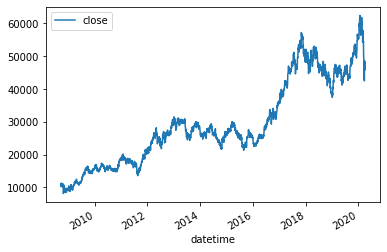

In [143]:
samsung.plot(y='close')